In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split

# import the breast cancer dataset
diagnoses = pd.read_csv('../representation_learning/testing_methods/datasets/breast_cancer.csv')

# select columns for training and testing
X = diagnoses[diagnoses.columns[2:]]
y = diagnoses['diagnosis']

# normalize the data
X = (X - X.mean()) / X.std()

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
293,-0.646215,-0.425397,-0.676120,-0.631373,-0.898760,-0.907375,-0.776712,-0.673125,0.231198,-0.799904,...,-0.663983,0.011841,-0.681830,-0.637180,0.198464,-0.498708,-0.673884,-0.353041,0.323667,-0.768264
332,-0.824986,0.132608,-0.824275,-0.760382,0.642750,-0.692086,-1.051098,-1.065286,0.468301,-0.356584,...,-0.887435,0.016722,-0.903242,-0.780676,0.439349,-1.001516,-1.240692,-1.435918,0.632391,-1.036794
565,1.703356,2.083301,1.614511,1.722326,0.102368,-0.017817,0.692434,1.262558,-0.217473,-1.057681,...,1.535369,2.045599,1.420690,1.493644,-0.690623,-0.394473,0.236365,0.733182,-0.531387,-0.973122
278,-0.152464,-0.337046,-0.235773,-0.234685,-1.200237,-1.208439,-0.863390,-0.941662,-0.870417,-1.076093,...,-0.159146,0.068786,-0.248529,-0.248496,-1.198672,-1.131620,-0.796592,-0.954724,-0.914464,-1.180195
489,0.727206,0.211659,0.622700,0.576024,-1.520911,-0.629033,-0.656165,-0.666166,0.125414,-1.352283,...,0.602248,0.143628,0.596347,0.357275,-1.378241,0.239836,-0.117381,-0.414350,2.871047,-0.427202


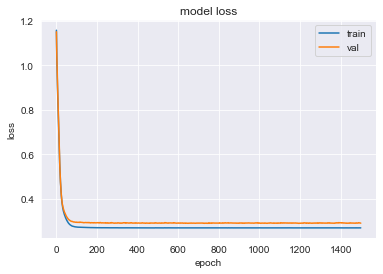

In [19]:
from keras import layers
from keras.models import Sequential
from keras.losses import MeanSquaredError
from keras.models import Model
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# our model is an autoencoder with non-linear encoder and linear decoder
non_linear_autoencoder = Sequential(
    [
        layers.Input(30),
        layers.Dense(3, activation=None, name='hidden'),
        layers.Dense(30, activation=None, name='output')
    ]
)

# compile the model with the optimizer and loss
non_linear_autoencoder.compile(optimizer='adam', loss=MeanSquaredError())

# train the autoencoder for N epochs
train_history = non_linear_autoencoder.fit(X_train, X_train,
                                           epochs=1500,
                                           batch_size=32,
                                           shuffle=True,
                                           validation_data=(X_test, X_test),
                                           verbose=0)

# we now define the linear encoder that will be used to obtain the latent space
non_linear_encoder = Model(
    inputs=non_linear_autoencoder.inputs,
    outputs=non_linear_autoencoder.get_layer(name='hidden').output,
)

latent_space = non_linear_encoder.predict(X).T

plt.plot(train_history.history['loss'])
plt.plot(train_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc=1)
plt.show()

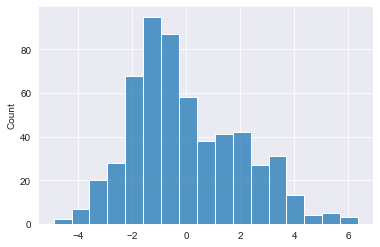

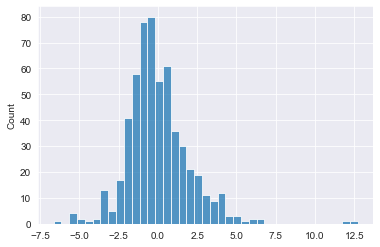

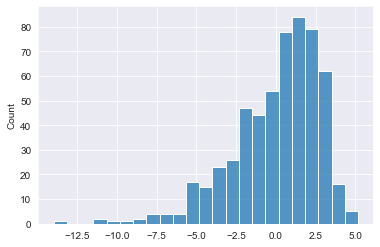

In [20]:
import seaborn as sns

for i in range(3):
    sns.histplot(x=latent_space[i])
    plt.show()

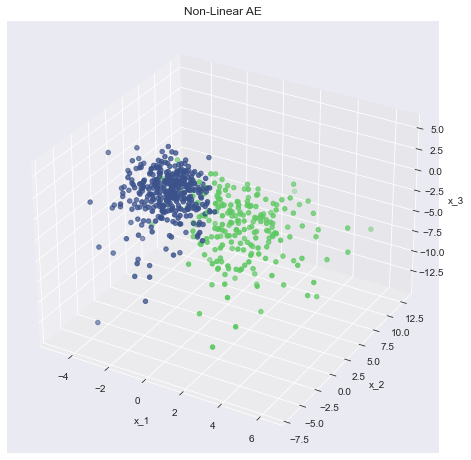

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.colors import ListedColormap

# convert classes into a format that can be used as a hue
labels = y == 'M'

# plot the latent spaces colored by class
for latent, name in zip([latent_space],
                              ['Non-Linear AE']):

    # figure setup and visual features
    fig = plt.figure(figsize=(7,6))
    ax = Axes3D(fig)
    viridis_map = ListedColormap(sns.color_palette('viridis', 3))

    # plot the data in a 3D grid
    ax.scatter(latent[0], latent[1], latent[2], c=labels,  marker='o', cmap=viridis_map)
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.set_zlabel('x_3')
    # ax.set_xlim(-0.1, 1.1)
    # ax.set_ylim(-0.1, 1.1)
    # ax.set_zlim(-0.1, 1.1)
    ax.set_title(name)

    # display and save figure
    plt.savefig(f'figures/latent_space_{name}.png', dpi=200)
    plt.show()

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

def apply_classifiers(latent_x_train, latent_x_test):

    # using KNNs for classification
    knn = KNeighborsClassifier(n_neighbors=20).fit(latent_x_train, y_train)
    print("KNN test score:", knn.score(latent_x_test, y_test))
    print("KNN train score:", knn.score(latent_x_train, y_train))

    # using SVMs for classification
    svm = SVC().fit(latent_x_train, y_train)
    print("SVM test score:", svm.score(latent_x_test, y_test))
    print("SVM train score:", svm.score(latent_x_train, y_train))

    # using random forests for classification
    rfc = RandomForestClassifier(max_depth=5, random_state=0).fit(latent_x_train, y_train)
    print("RF test score:", rfc.score(latent_x_test, y_test))
    print("RF train score:", rfc.score(latent_x_train, y_train))

    # using logistic regression for classification
    lrc = LogisticRegression(random_state=0).fit(latent_x_train, y_train)
    print("LR test score:", lrc.score(latent_x_test, y_test))
    print("LR train score:", lrc.score(latent_x_train, y_train))

    return [knn.score(latent_x_test, y_test), svm.score(latent_x_test, y_test),
            rfc.score(latent_x_test, y_test), lrc.score(latent_x_test, y_test)]


# get the train and test latent spaces
latent_train = non_linear_encoder.predict(X_train)
latent_test = non_linear_encoder.predict(X_test)
apply_classifiers(latent_train, latent_test)

KNN test score: 0.9230769230769231
KNN train score: 0.9483568075117371
SVM test score: 0.916083916083916
SVM train score: 0.9553990610328639
RF test score: 0.9300699300699301
RF train score: 0.9882629107981221
LR test score: 0.9300699300699301
LR train score: 0.960093896713615


[0.9230769230769231, 0.916083916083916, 0.9300699300699301, 0.9300699300699301]